Allison Schlissel  
Project 3: America's Next Top Model  
Predicting General Election on the County Level with Census Data  
August 5, 2016

## Imports

In [1]:
import csv
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns

## 2008 Data  
#### CSV files contain county demographics recorded by the American Community Survey

In [2]:
list_of_files_08 = ['ACS_08_1YR_S0101_with_ann.csv', 'ACS_08_1YR_S0801_with_ann.csv', 'ACS_08_1YR_S1101_with_ann.csv', 
                   'ACS_08_1YR_S1201_with_ann.csv', 'ACS_08_1YR_S1301_with_ann.csv', 'ACS_08_1YR_S1401_with_ann.csv', 
                   'ACS_08_1YR_S1501_with_ann.csv', 'ACS_08_1YR_S1701_with_ann.csv', 'ACS_08_1YR_S1901_with_ann.csv', 
                   'ACS_08_1YR_S2101_with_ann.csv', 'ACS_08_1YR_S2201_with_ann.csv', 'ACS_08_1YR_S2301_with_ann.csv', 
                   'ACS_08_1YR_S2401_with_ann.csv', 'ACS_08_1YR_S2502_with_ann.csv']

In [3]:
#read the files

list_08 = []
for file_ in list_of_files_08:
    dfs = pd.read_csv(file_,index_col=None, header=1)
    list_08.append(dfs)
countiesframe_08 = pd.concat(list_08, axis = 1)

In [5]:
countiesframe_08.shape

(790, 3488)

In [6]:
#drop 'margin of error' columns

newcounties_08=countiesframe_08
# removed extra columns
for i in newcounties_08.columns:
    if 'Margin of Error' in i:
        newcounties_08=newcounties_08.drop(i,axis=1)
        

print len(newcounties_08.columns)

1765


In [7]:
#drop duplicates

newcounties_08 = newcounties_08.T.drop_duplicates().T
print len(newcounties_08.columns)

1567


## Election Results 2008

link to elections data: http://www-personal.umich.edu/~mejn/election/2008/

In [8]:
results_08 = pd.read_csv('results_08.csv')

In [9]:
#new column to indicate whether a county voted democrat

results_08['Democrat'] = np.where(results_08['OBAMA']>= results_08['MCCAIN'], '1', '0')

In [10]:
newcounties_08.shape

(790, 1567)

In [11]:
#function to make Geography strings in both dataframes uniform

def county_and_state(df):
    new_string = df.COUNTY + 'County, ' + df.STATE
    return new_string

results_08['Geography'] = results_08.apply(county_and_state, axis=1)

In [12]:
# reduce columns in results dataframe to be merged with newcounties_08.csv

results_08 = results_08[['Geography', 'Democrat']]

In [13]:
results_08 = results_08.convert_objects(convert_numeric=True)

/Users/allison18paige/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [14]:
# merge newcounties_08 and results_08
newcounties_08 = pd.merge(left=newcounties_08, right=results_08, left_on='Geography', right_on='Geography')

In [15]:
newcounties_08.shape

(747, 1568)

In [16]:
# take out special characters

newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace('- ', ''))
newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace('; ',''))
newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace('$',''))
newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace('  ',' '))
newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace(' ','_'))
newcounties_08 = newcounties_08.rename(columns=lambda x: x.replace(', ',''))

In [17]:
#replace missing values with NaNs

newcounties_08 = newcounties_08.replace('N', np.NaN)

## Model 2008

In [18]:
y = newcounties_08['Democrat']
X = newcounties_08.ix[:,3:-1]
X.shape

(747, 1564)

In [19]:
X.select_dtypes(include=['object'])

,TotalEstimateTotal_population_SELECTED_AGE_CATEGORIES_16_years_and_over,MaleEstimateTotal_population_SELECTED_AGE_CATEGORIES_16_years_and_over,FemaleEstimateTotal_population_SELECTED_AGE_CATEGORIES_16_years_and_over,MaleEstimateTotal_population_SUMMARY_INDICATORS_Sex_ratio_(males_per_100_females),TotalEstimateWorkers_16_years_and_over,MaleEstimateWorkers_16_years_and_over,FemaleEstimateWorkers_16_years_and_over,"TotalEstimateWorkers_16_years_and_over_MEANS_OF_TRANSPORTATION_TO_WORK_Car,_truck,_or_van","MaleEstimateWorkers_16_years_and_over_MEANS_OF_TRANSPORTATION_TO_WORK_Car,_truck,_or_van","FemaleEstimateWorkers_16_years_and_over_MEANS_OF_TRANSPORTATION_TO_WORK_Car,_truck,_or_van",...,Renter-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_One_race_-Native_Hawaiian_and_Other_Pacific_Islander,Occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_One_race_-Some_other_race,Owner-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_One_race_-Some_other_race,Renter-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_One_race_-Some_other_race,Occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Two_or_more_races,Owner-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Two_or_more_races,Renter-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Two_or_more_races,Occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Hispanic_or_Latino_origin,Owner-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Hispanic_or_Latino_origin,Renter-occupied_housing_unitsEstimateOccupied_housing_units_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Hispanic_or_Latino_origin
0,79.7,77.7,81.6,(X),81260,42857,38403,95.3,94.6,96.0,...,NaN,0.7,NaN,NaN,0.9,NaN,NaN,1.7,1.3,3.2
1,79.7,78.3,81.0,(X),48297,25233,23064,95.0,93.4,96.7,...,NaN,0.8,NaN,NaN,0.6,NaN,NaN,1.5,1.0,3.1
2,79.9,79.2,80.6,(X),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,0.8,5.8
3,78.7,76.6,80.7,(X),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,2.6,20.7
4,77.7,77.9,77.4,(X),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,79.6,77.7,81.3,(X),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN
6,77.6,76.0,79.1,(X),43032,22360,20672,94.8,94.7,94.9,...,NaN,0.5,NaN,NaN,0.8,0.7,0.9,1.1,0.6,2.2
7,78.8,77.1,80.3,(X),304587,154731,149856,94.3,93.8,94.7,...,NaN,0.9,0.1,2.5,1.0,1.0,0.9,2.3,1.2,4.5
8,81.3,79.5,82.9,(X),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,80.4,80.2,80.7,(X),61828,32981,28847,90.5,89.4,91.8,...,NaN,0.1,NaN,NaN,0.6,0.7,0.2,1.1,0.6,2.2


In [20]:
X = X.select_dtypes(exclude=['object'])
X.shape

#X.isnull()

(747, 743)

In [21]:
#ensure no duplicates

for e,i in enumerate(X.columns):
    try: 
        test=X[X[i].isfinite()==True]
        #print e,i,len(test)
        if len(test)>0: 
            print i
    except:
        pass

In [22]:
Cols = list(newcounties_08.columns)
for i,item in enumerate(newcounties_08.columns):
    if item in newcounties_08.columns[:i]: Cols[i] = "toDROP"
newcounties_08.columns = Cols
newcounties_08 = newcounties_08.drop("toDROP",1)

In [23]:
y.value_counts()

0    405
1    342
Name: Democrat, dtype: int64

In [24]:
my_list=[]
for i in X.columns:
    if i not in my_list:
        my_list.append(i)
    else:
        print 'doubles',i

doubles TotalEstimatePERCENT_IMPUTED_Marital_status
doubles TotalEstimatePopulation_18_to_24_years


In [25]:
X = X.drop('TotalEstimatePERCENT_IMPUTED_Marital_status', 1)
X = X.drop('TotalEstimatePopulation_18_to_24_years', 1)

In [26]:
my_list=[]
for i in X.columns:
    if i not in my_list:
        my_list.append(i)
    else:
        print 'doubles',i

In [27]:
for i in X.columns:
    test = X[X[i].isnull()==True]
    if len(test) > 0:
        print test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Accuracy

### SVC

In [29]:
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_svc

0.56444444444444442

### KNN

In [30]:
max_accuracy = {}
for i in range (1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    max_accuracy[i] = acc

print acc
max(max_accuracy, key=max_accuracy.get)

0.715555555556


20

### Logistic Regression

In [31]:
logistics = LogisticRegression()
logistics.fit(X_train, y_train)
acc = accuracy_score(y_test, logistics.predict(X_test))
acc

0.72888888888888892

### Random Forest

In [32]:
random_forest = RandomForestClassifier(random_state=4444, criterion='entropy', max_depth=600, bootstrap=False)
random_forest.fit(X_train, y_train)
acc_random_forest = accuracy_score(y_test, random_forest.predict(X_test))
acc_random_forest

0.79555555555555557

## ROC / AUC

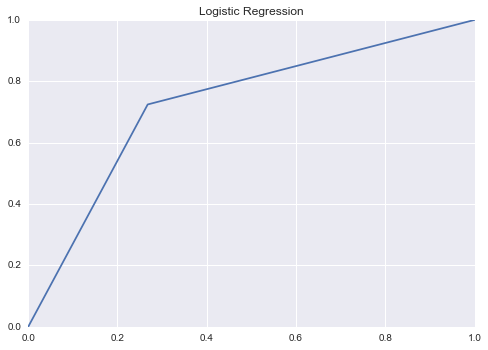

Logistic AUC Score:  0.728386630243
Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.73      0.75       127
          1       0.68      0.72      0.70        98

avg / total       0.73      0.73      0.73       225



In [33]:
fpr, tpr, thresholds = roc_curve(y_test, logistics.predict(X_test))

plt.plot(fpr, tpr)
plt.title('Logistic Regression')
plt.show()

print 'Logistic AUC Score: ', roc_auc_score(y_test, logistics.predict(X_test))
print 'Classification Report:'
print classification_report(y_test, logistics.predict(X_test))

KNN AUC Score:  0.696770046601
Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.84      0.77       127
          1       0.73      0.55      0.63        98

avg / total       0.72      0.72      0.71       225



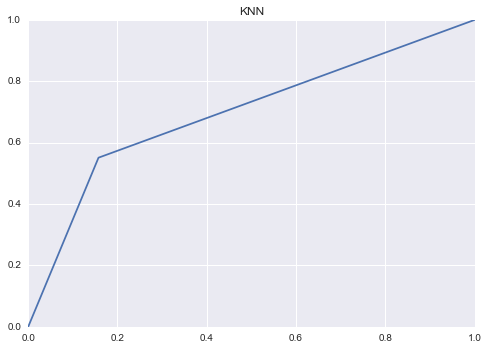

In [34]:
fpr, tpr, threshold = roc_curve(y_test, knn.predict(X_test))

plt.plot(fpr, tpr)
plt.title('KNN')
plt.show

print 'KNN AUC Score: ', roc_auc_score(y_test, knn.predict(X_test))
print 'Classification Report:'
print classification_report(y_test, knn.predict(X_test))

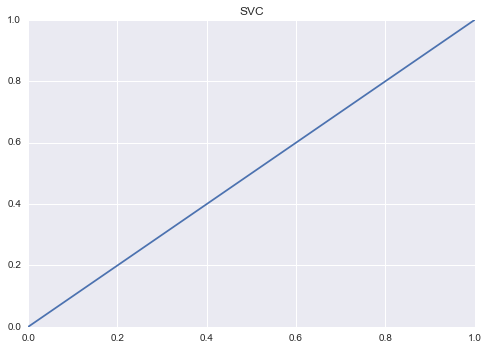

SVC AUC Score:  0.5
Classification Report:
             precision    recall  f1-score   support

          0       0.56      1.00      0.72       127
          1       0.00      0.00      0.00        98

avg / total       0.32      0.56      0.41       225



/Users/allison18paige/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
fpr, tpr, thresholds = roc_curve(y_test, svc.predict(X_test))

plt.plot(fpr, tpr)
plt.title('SVC')
plt.show()

print 'SVC AUC Score: ', roc_auc_score(y_test, svc.predict(X_test))
print 'Classification Report:'
print classification_report(y_test, svc.predict(X_test))

Random Forest AUC Score:  0.785111682468
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       127
          1       0.80      0.70      0.75        98

avg / total       0.80      0.80      0.79       225



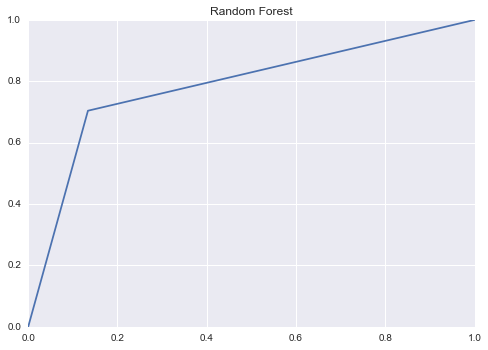

In [36]:
fpr, tpr, threshold = roc_curve(y_test, random_forest.predict(X_test))

plt.plot(fpr, tpr)
plt.title('Random Forest')
plt.show

print 'Random Forest AUC Score: ', roc_auc_score(y_test, random_forest.predict(X_test))
print 'Classification Report:'
print classification_report(y_test, random_forest.predict(X_test))

## Most Important Features in Random Forest

In [38]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(X_train.columns)[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature Now_married_(except_separated)EstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_White_alone,_not_Hispanic_or_Latino (0.037781)
2. feature Never_marriedEstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_White (0.031540)
3. feature Below_poverty_levelEstimatePopulation_for_whom_poverty_status_is_determined_EMPLOYMENT_STATUS_Civilian_labor_force_16_years_and_over_Employed_Female (0.029592)
4. feature Below_poverty_levelEstimateUnrelated_individuals_for_whom_poverty_status_is_determined_Male (0.023345)
5. feature Below_poverty_levelEstimatePopulation_for_whom_poverty_status_is_determined_EMPLOYMENT_STATUS_Civilian_labor_force_16_years_and_over_Employed (0.018265)
6. feature Below_poverty_levelEstimatePopulation_for_whom_poverty_status_is_determined_WORK_EXPERIENCE_Population_16_years_and_over_Worked_part-time_or_part-year_in_the_past_12_months (0.016425)
7. feature Below_poverty_levelEstimateUnrelated_individua

## Histograms of Most Important Features

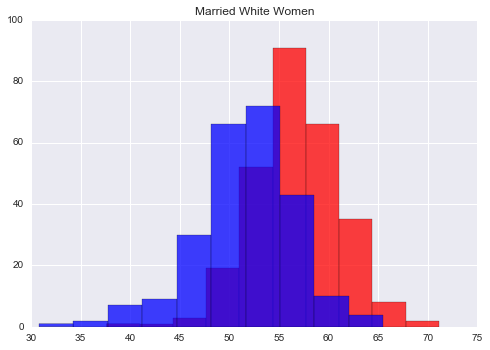

In [39]:
X_train[y_train == 0]['Now_married_(except_separated)EstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_White_alone,_not_Hispanic_or_Latino'
                     ].hist(color='r', alpha=.75)
X_train[y_train == 1]['Now_married_(except_separated)EstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_White_alone,_not_Hispanic_or_Latino'].hist(color='b', alpha=.75)

plt.title('Married White Women')

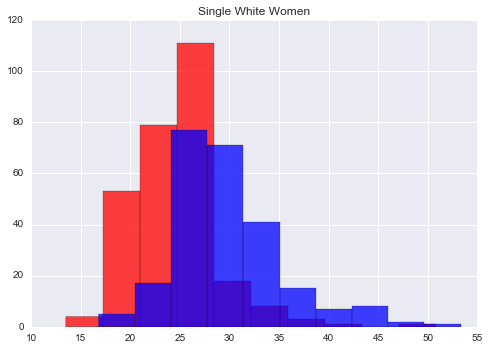

In [40]:
X_train[y_train == 0]['Never_marriedEstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_White'].hist(color='r', alpha=0.75)
X_train[y_train == 1]['Never_marriedEstimatePopulation_15_years_and_over_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_White'].hist(color='b', alpha=0.75)
plt.title('Single White Women')

In [41]:
f1 = 'Below_poverty_levelEstimatePopulation_for_whom_poverty_status_is_determined_EMPLOYMENT_STATUS_Civilian_labor_force_16_years_and_over_Employed_Female'
f2 = 'MaleEstimatePopulation_18_to_24_years'
f3 = 'Median_earnings_(dollars)_for_femaleEstimateCivilian_employed_population_16_years_and_over'

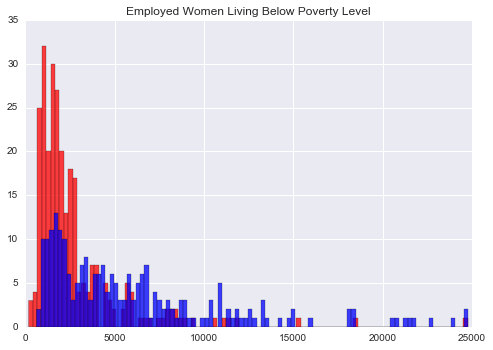

In [42]:
X_train[y_train == 0][f1].hist(color='r', bins = 100, alpha=0.75)
X_train[(y_train == 1) & (X_train[f1] < 25000)][f1].hist(color='b', bins = 100,alpha=0.75)
plt.title('Employed Women Living Below Poverty Level')

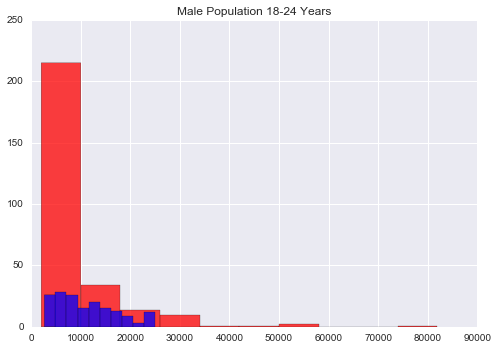

In [43]:
X_train[y_train == 0][f2].hist(color='r', alpha=0.75)
X_train[(y_train == 1) & (X_train[f2] < 25000)][f2].hist(color='b', alpha=0.75)
plt.title('Male Population 18-24 Years')

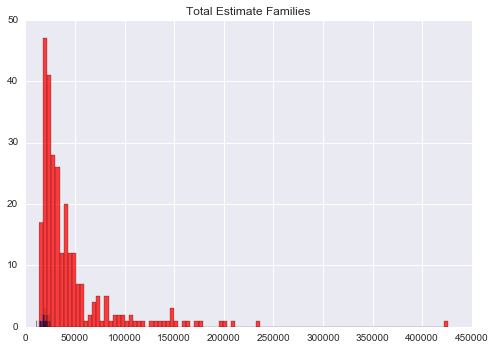

In [44]:
f4 = 'TotalEstimateFAMILIES_Total_families'

X_train[y_train == 0][f4].hist(color='r', bins=100, alpha=0.75)
X_train[(y_train == 1) & (X_train[f4] < 25000)][f4].hist(color='b', bins=100, alpha=0.75)
plt.title('Total Estimate Families')

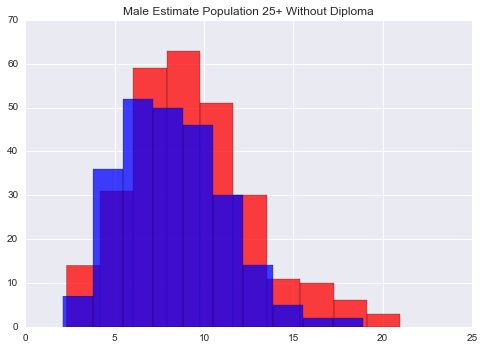

In [45]:
f5 = 'MaleEstimatePopulation_25_years_and_over_9th_to_12th_grade,_no_diploma'

X_train[y_train == 0][f5].hist(color='r', alpha=0.75)
X_train[(y_train == 1) & (X_train[f5] < 25000)][f5].hist(color='b', alpha=0.75)
plt.title('Male Estimate Population 25+ Without Diploma')

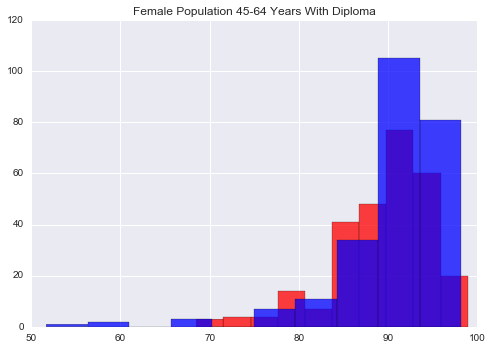

In [46]:
f6 = 'FemaleEstimatePopulation_45_to_64_years_High_school_graduate_or_higher'

X_train[y_train == 0][f6].hist(color='r', alpha=0.75)
X_train[(y_train == 1) & (X_train[f6] < 25000)][f6].hist(color='b', alpha=0.75)
plt.title('Female Population 45-64 Years With Diploma')

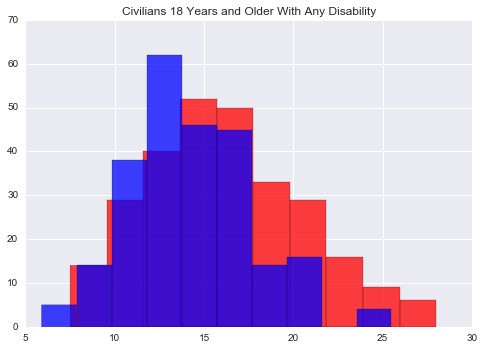

In [47]:
f7 = 'TotalEstimateDISABILITY_STATUS_Civilian_population_18_years_and_over_With_any_disability'

X_train[y_train == 0][f7].hist(color='r', alpha=0.75)
X_train[(y_train == 1) & (X_train[f7] < 25000)][f7].hist(color='b', alpha=0.75)
plt.title('Civilians 18 Years and Older With Any Disability')